# scRNA-seq distinguishes Projection Neurons and Astrocytes (Fig. 1)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
df_logCPM_all = pd.read_csv("../data/htseq_logCPM_hq.tab.gz", sep="\t", header=0, index_col=0) # CPM
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

# Filter for cells in Figure 1 (GH146, C155, astrocyte)

In [7]:
# Load names of high quality neurons (4/5 markers)
names_hq_neurons = []
with open("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())

# Get names of neurons, astrocytes
selector = (((df_libs["genotype"] == "GH146-GFP")) &
            (df_libs["num_cells"] == 1))
names_neuron = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]
print "Projection Neurons", len(names_neuron)

Projection Neurons 946


In [10]:
# Load names of high quality neurons (4/5 markers)
names_hq_neurons = []
with open("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())

# Get names of neurons, astrocytes
selector = (((df_libs["genotype"] == "GH146-GFP")) &
            (df_libs["num_cells"] == 1))
names_neuron = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]
print "Projection Neurons", len(names_neuron)

selector = ((df_libs["genotype"] == "astrocyte") &
            (df_libs["num_cells"] == 1))
names_astrocyte = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index]
print "Astrocytes", len(names_astrocyte)

# Filter for these cells
names_Fig1 = names_neuron + names_astrocyte
df = df_logCPM_all[list(names_Fig1)]
print "Number of cells", len(names_Fig1)

# Display number of cells of each genotype to confirm
df_libs.loc[df.columns]["genotype"].value_counts()

Projection Neurons 946
Astrocytes 67
Number of cells 1013


GH146-GFP    946
astrocyte     67
Name: genotype, dtype: int64

# Display cells using PCA/TSNE on overdispersed genes

In [11]:
# Rename df for convenience
X = df

# Get top overdispersed genes
myDispersion = sct.dispersion(X)
myDispersion.calc_dispersion() # calculate overdispersion
genes_overdispersed = myDispersion.get_hits(N=500)
Y = X.loc[genes_overdispersed.index]

../resources/sct.py:254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X["max"] = np.max(self.X, axis=1)
../resources/sct.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X.sort_values(by="max", ascending=False, inplace=True)
../resources/sct.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.X.drop("max", axis=1, inplace=True)
../resources/sct.py:124: SettingWithCopyWarning: 
A value is trying to be set on

In [22]:
# Calculate PCA
from sklearn.decomposition import PCA
myPCA = sct.PCA(Y, df, 7) # number of significant PCs was determined using shuffling performed elsewhere in parallel fashion
myPCA.pca()
Y_pca = pd.DataFrame(myPCA.X_pca.T)

In [23]:
# Calculate TSNE
reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(Y_pca, df, df_libs)
myTSNE.calc_TSNE(perplexity=30, learning_rate=500)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1013
[t-SNE] Computed conditional probabilities for sample 1013 / 1013
[t-SNE] Mean sigma: 0.133881
[t-SNE] Iteration 25: error = 1.5349064, gradient norm = 0.0077562
[t-SNE] Iteration 50: error = 1.3303595, gradient norm = 0.0055724
[t-SNE] Iteration 75: error = 0.9069957, gradient norm = 0.0020027
[t-SNE] Iteration 100: error = 0.8551509, gradient norm = 0.0016325
[t-SNE] Error after 100 iterations with early exaggeration: 0.855151
[t-SNE] Iteration 125: error = 0.7832694, gradient norm = 0.0012136
[t-SNE] Iteration 150: error = 0.7627271, gradient norm = 0.0011009
[t-SNE] Iteration 175: error = 0.7578522, gradient norm = 0.0010780
[t-SNE] Iteration 200: error = 0.7565343, gradient norm = 0.0010691
[t-SNE] Iteration 225: error = 0.7561619, gradient norm = 0.0010693
[t-SNE] Iteration 250: error = 0.7560645, gradient norm = 0.0010682
[t-SNE] Iteration 275: error = 0.7560372, gradient 

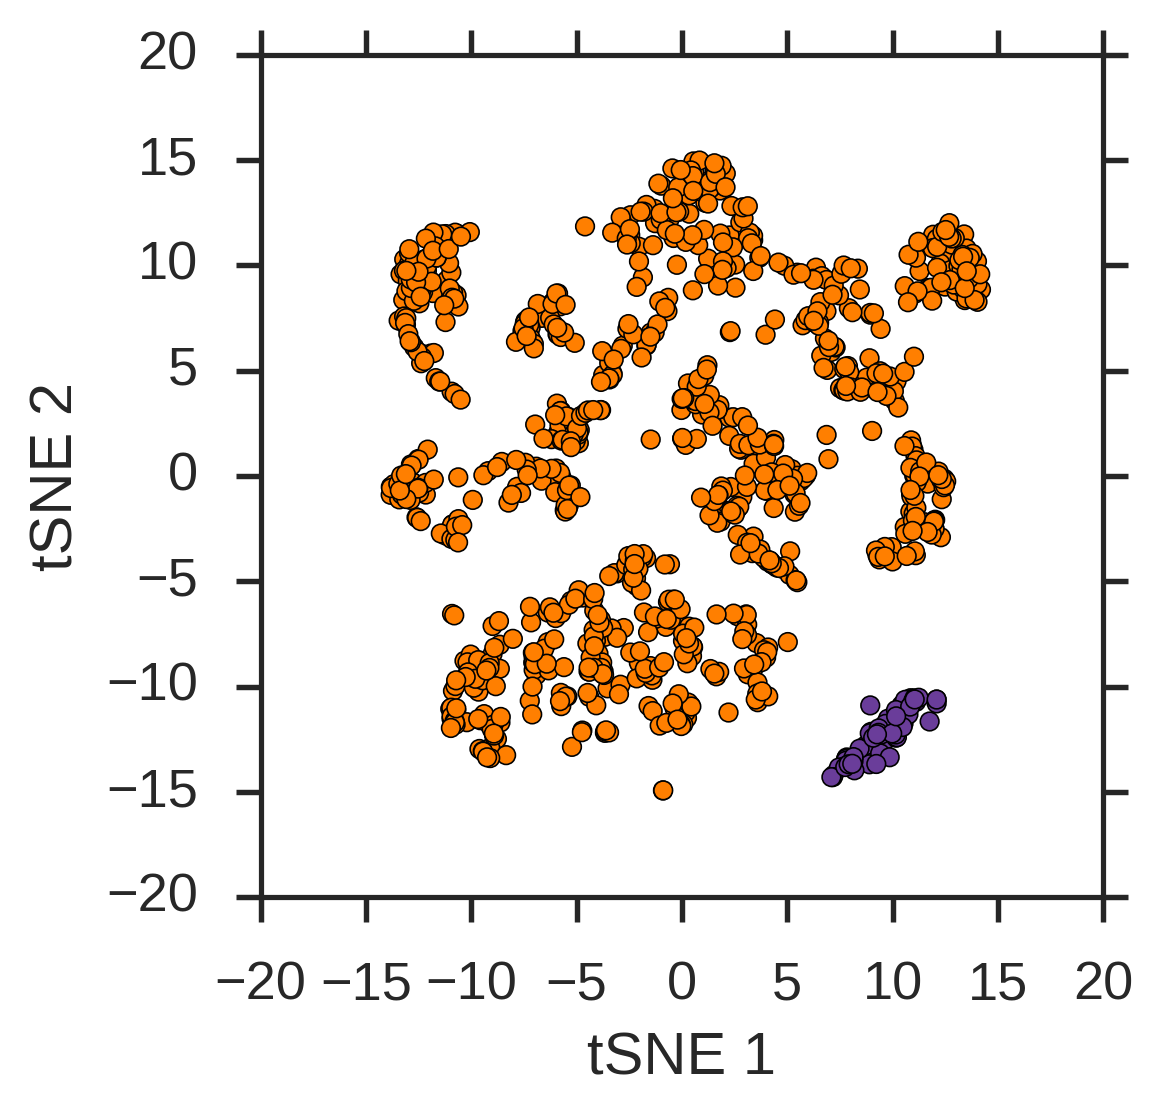

In [24]:
# Plot TSNE
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="genotype")

# Find glial markers using differential expression (astrocyte vs neurons)

In [17]:
# Get names of GH146 cells
selector = ((df_libs["genotype"] == "GH146-GFP") &
            (df_libs["num_cells"] == 1))
names1 = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]

# Get names of astrocyte cells
selector = ((df_libs["genotype"] == "astrocyte") &
            (df_libs["num_cells"] == 1))
names2 = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index]

# Calculate differential expression
df_DE = sct.calc_DE_mannwhitneyu(X.head(100), names1, names2)

In [18]:
df_DE.head(n=20)

,meanA,meanB,medianA,medianB,pvalue,pvalue_adj
symbol,,,,,,
alrm,0.030553,13.428085,0.000000,14.716560,3.761040e-188,3.761040e-186
Eaat1,0.044250,12.742906,0.000000,13.847369,4.868311e-187,4.868311e-185
Cyp4g15,0.010715,11.388031,0.000000,12.885997,6.044816e-186,6.044816e-184
Gat,0.113891,12.249663,0.000000,14.176073,5.144871e-147,5.144871e-145
Gs2,0.220918,14.897111,0.000000,15.351957,2.156362e-131,2.156362e-129
mfas,0.119204,11.058499,0.000000,13.271869,3.330102e-122,3.330102e-120
Msr-110,0.030873,8.390756,0.000000,12.248149,4.209643e-116,4.209643e-114
Tre1,0.078640,8.663542,0.000000,12.370683,6.928791e-110,6.928791e-108
Obp44a,0.380301,13.808002,0.000000,13.907562,2.252743e-107,2.252743e-105


# Display heatmap of neuronal and glial markers

In [19]:
# Choose genes
genes = ["elav", "brp", "Syt1", "nSyb", "CadN", "alrm", "Eaat1",
         "Cyp4g15", "Gat", "Gs2", "mfas", "Msr-110", "Tre1", "Obp44a"]
Z = X.loc[genes]
print Z.shape

(14, 1013)


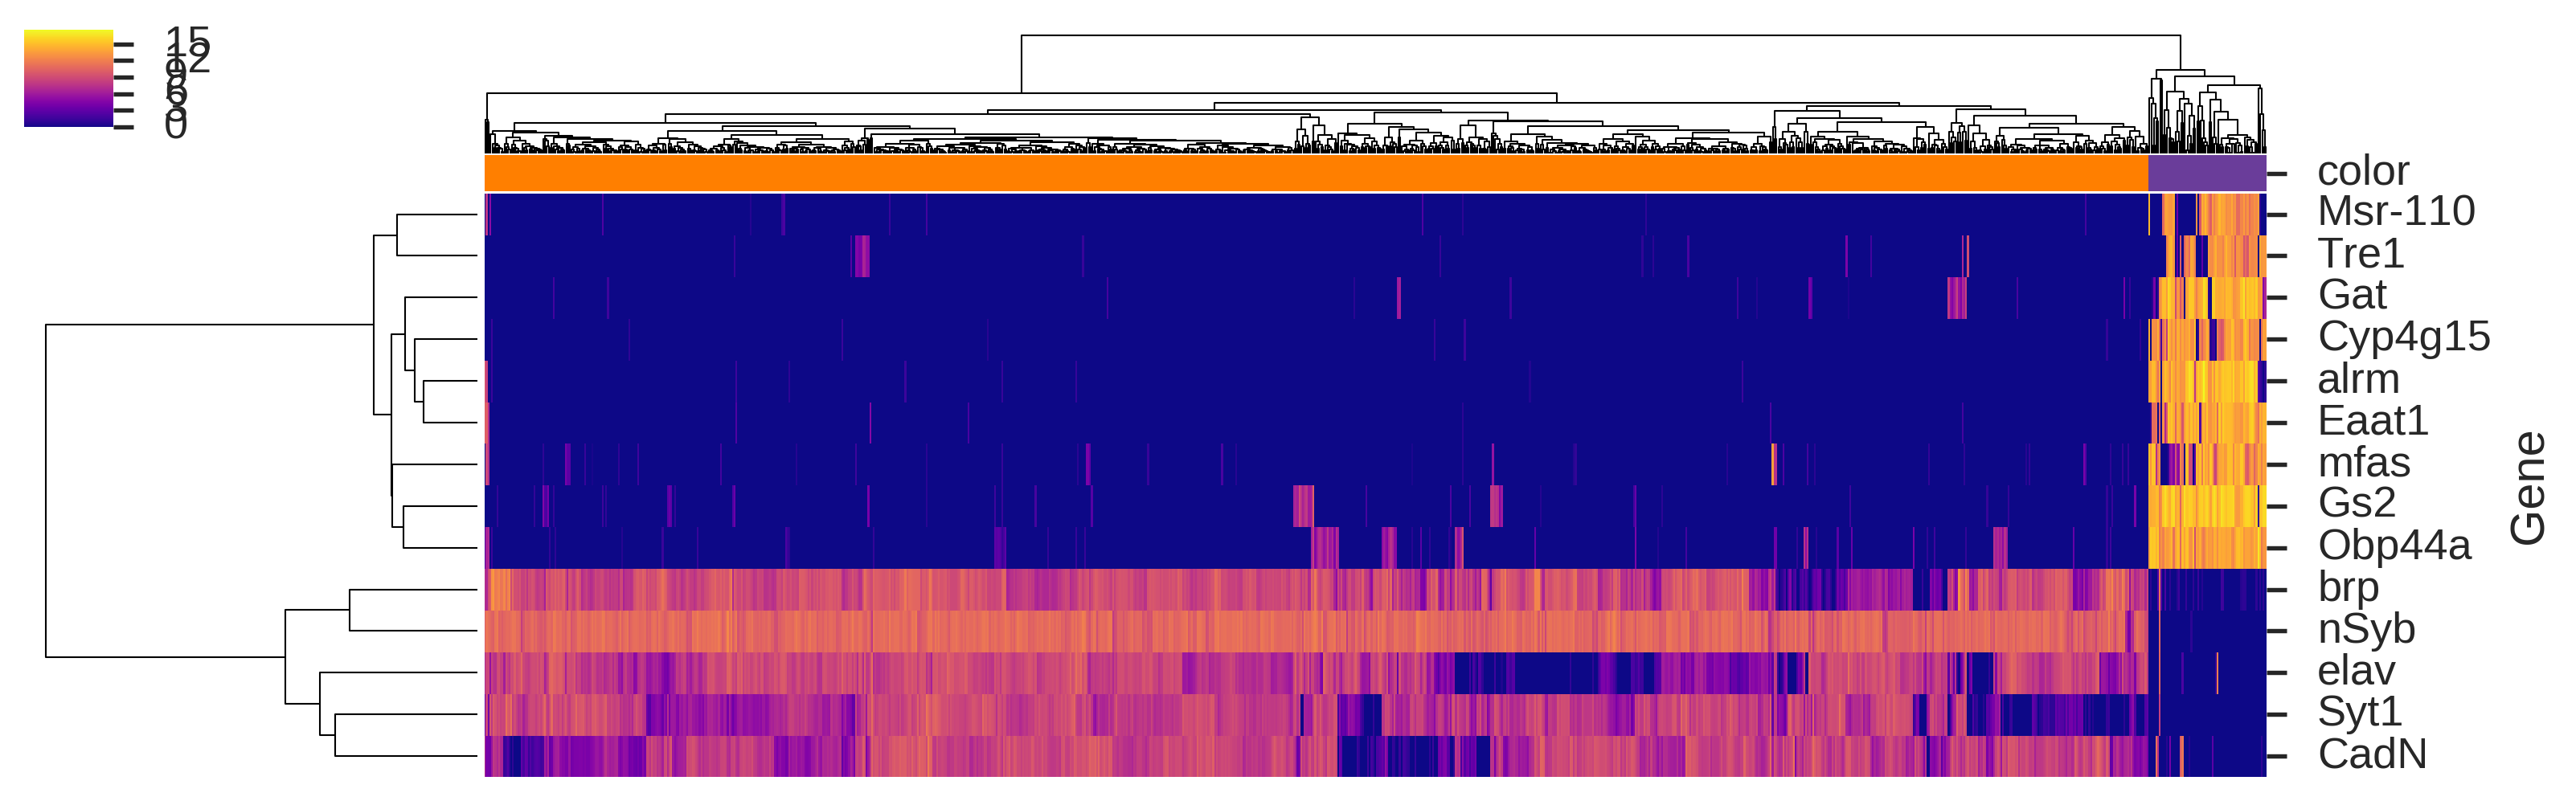

In [20]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["color"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="complete", cmap="plasma", figsize=(12,4), col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig(output_dir+"/NeuronsAstrocytes_ClusterMap.pdf")